In [1]:
import numpy as np
from HINTS import *
from HINTS_additive_pdf import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

In [2]:
def proposal1(state, index):
    return(state + 0.1 * randn(state.shape[0]), 0.0) # new state, optional evaluation at new state, correction for asymmetry  



0.999731072027148 -0.02758935155325297 0.6396832684361033


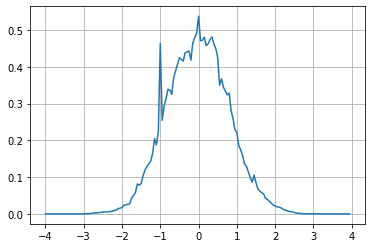

In [3]:

# visualise stepped Gaussian ... has nasty properties but we can reduce noise
xs = np.arange(-4.0, 4.0, 0.05)
N = 1000
np.random.seed(0)
e = TestFnStepped(proposal1, N, reduce_variance = False)
exs = np.expand_dims(xs, axis=1)
plt.figure()

ysum = np.zeros(xs.size)
for i in range(N):
    ys = [e.evaluate_prob(x, i) for x in exs]
    ysum += ys
    #plt.gca().plot(xs, ys)
tgt = ysum/N # pdf
plt.gca().plot(xs, tgt) 
plt.grid() 

print(np.sum(tgt) * 0.05, np.sum(tgt * xs)/np.sum(tgt), np.sum(tgt * xs * xs)/np.sum(tgt)) # area under curve = 1, moments
# variance is not = 1 - maybe it is 2/3??

1.0109811607661237 -0.01758913453582651 0.6337130645991687


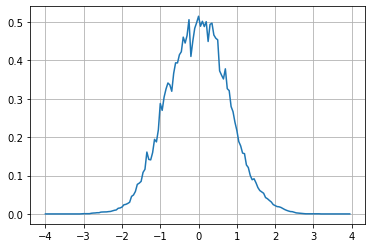

In [4]:

# visualise stepped Gaussian ... has nasty properties but we can reduce noise
xs = np.arange(-4.0, 4.0, 0.05)
np.random.seed(0)
N = 1000
e = TestFnStepped(proposal1, N, reduce_variance = True)
exs = np.expand_dims(xs, axis=1)
plt.figure()

ysum = np.zeros(xs.size)
for i in range(N):
    ys = [e.evaluate_prob(x, i) for x in exs]
    ysum += ys
    #plt.gca().plot(xs, ys)
tgt = ysum/N # pdf
plt.gca().plot(xs, tgt) 
plt.grid() 

print(np.sum(tgt) * 0.05, np.sum(tgt * xs)/np.sum(tgt), np.sum(tgt * xs * xs)/np.sum(tgt)) # area under curve = 1, moments
# variance is not = 1 - maybe it is 2/3??

In [5]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults
#HINTS payoff comes for large num scenarios > 1000
# checked regular MCMC is accurate (1 level, lbf = 6)
if True:
    args.levels = 5
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 1000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 1024
    args.design = np.array([NUM_SCENARIOS])
    iterations = 42094# YOU NEED TO ADJUST THIS TOMATCH EXACT # EVALS OF THE HINTS WE ARE COMPARING WITH

print(NUM_SCENARIOS)

# design now has levels + 1 entries
# additive log probability is more natural from a Bayesian perspective but both are valid

args.additive = False
args.T = 1.0 #top level
#args.dT = 0.0 if args.additive else 0.5 # temperature increment by level (mainly for optimisation or averaging structure)
args.dT = 0.0 


print(args.__dict__)

1024
{'levels': 5, 'design': array([1, 4, 4, 4, 4, 4]), 'additive': False, 'T': 1.0, 'dT': 0.0}


In [6]:

#g = TestFn(proposal1, NUM_SCENARIOS, args.additive, args.grad_scale)
g = TestFnStepped(proposal1, NUM_SCENARIOS)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)

nsd = 4.0 # for diagnostics only
bins = 64

histogram = np.zeros([bins], dtype = float)

RESET
5
[   1    4   16   64  256 1024]
1024
[1. 1. 1. 1. 1. 1.]
[0.52738853]


In [7]:
for t in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # diagnostic histogram
    if (abs(state[0]) < nsd): # ignoring samples outside diagnostic range
        j = int((state[0] + nsd) * bins/(2.0 * nsd))
        histogram[j] += 1.0
    # show progress
    if ((t%50)==49):
        print(t+1, hmc.acceptances, hmc.rejections)
        #print(cache.stats(enable=True, reset = True))


50 [49930 10669  2147   583   156    43] [1270 2131 1053  217   44    7]
100 [99954 21474  4381  1152   300    85] [2446 4126 2019  448  100   15]
150 [150036  32226   6549   1702    459    127] [3564 6174 3051  698  141   23]
200 [200048  42946   8770   2251    616    168] [4752 8254 4030  949  184   32]
250 [249931  53555  10913   2820    777    212] [ 6069 10445  5087  1180   223    38]
300 [299865  64195  13059   3380    937    258] [ 7335 12605  6141  1420   263    42]
350 [349847  74839  15210   3948   1086    297] [ 8553 14761  7190  1652   314    53]
400 [399814  85620  17374   4494   1245    340] [ 9786 16780  8226  1906   355    60]
450 [449698  96155  19507   5044   1400    385] [11102 19045  9293  2156   400    65]
500 [499599 106905  21696   5619   1562    430] [12401 21095 10304  2381   438    70]
550 [549577 117598  23875   6178   1703    473] [13623 23202 11325  2622   497    77]
600 [599544 128349  26059   6729   1860    519] [14856 25251 12341  2871   540    81]
650 [

In [10]:
print(histogram)
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

[ 0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  2.  2.  1.  4.
  0. 15. 17. 10. 21. 23. 15. 35. 53. 53. 69. 63. 57. 71. 64. 53. 53. 49.
 41. 45. 43. 30. 28. 15. 12. 16.  9.  8.  7.  7.  0.  0.  1.  0.  0.  4.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[998992 213817  43345  11224   3118    869]
[25008 42183 20655  4776   882   131]
[0.97557812 0.83522266 0.67726562 0.7015     0.7795     0.869     ]


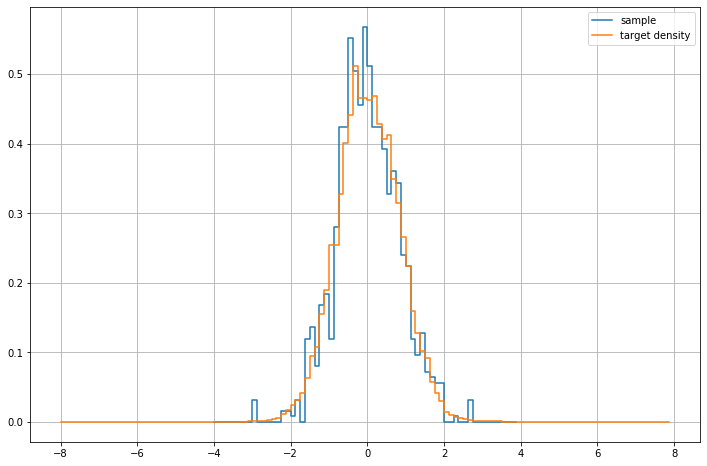

In [15]:
# compare densities (sampled vs target)

fig = plt.figure(figsize=[12,8])
ax1 = plt.gca()
xs1 = np.arange(bins, dtype = float) * (2.0 * nsd)/bins - nsd 

#logprob = np.log(histogram + 0.01)

dx = (2.0 * nsd)/bins
plt.plot(xs1, (histogram/np.sum(histogram))/dx, label = "sample", drawstyle = 'steps-post')

xs = np.arange(-2.0 * nsd, 2.0 * nsd, dx)
exs = np.expand_dims(xs, axis=1)

# do not create a new test function here... use the same one
if args.additive:
    ys = [sum([g.evaluate_prob(x, i) for i in range(NUM_SCENARIOS)]) for x in exs]
else:
    ys = [sum([g.evaluate_prob(x, i)/NUM_SCENARIOS for i in range(NUM_SCENARIOS)]) for x in exs]

plt.plot(xs, ys, label = 'target density', drawstyle = 'steps-post')
plt.legend()
plt.grid()
